# Road Lane Detection Using UNET

In [1]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# train path
train_path = '/kaggle/input/tusimple-preprocessed-data/tusimple_preprocessed/training'

In [3]:
# create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


In [4]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [5]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [6]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [7]:
Y.min(), Y.max()

(0, 1)

In [8]:
# we get 2000 images for training and evaluation
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [9]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (1800, 256, 320, 3)
Shape of X_val: (200, 256, 320, 3)
Shape of Y_train: (1800, 256, 320, 1)
Shape of Y_val: (200, 256, 320, 1)


In [11]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

53

In [12]:
# define the model's architecture

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model

def unet(input_size=(256,320,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet()

In [13]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 320, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 320, 64)         1792      ['rescaling[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 320, 64)         36928     ['conv2d[0][0]']              
                                                                                              

# MODEL TRAINING

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Define the path to the folder where you want to save TensorBoard logs
tensorboard_log_dir = '/kaggle/working/logs'

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

# train the model
epochs = 32
batch_size = 8

# Add TensorBoard callback to the list of callbacks
callbacks = [
    ModelCheckpoint("save_at_{epoch}.h5"),
    tensorboard_callback,
]


# Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)


Epoch 1/32


2023-12-15 04:02:15.519051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9542

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 213s 787ms/step - loss: 0.2839 - accuracy: 0.9542 - val_loss: 0.0409 - val_accuracy: 0.9565
Epoch 2/32
225/225 [==============================] - 177s 786ms/step - loss: 0.0268 - accuracy: 0.9649 - val_loss: 0.0205 - val_accuracy: 0.9693
Epoch 3/32
225/225 [==============================] - 178s 789ms/step - loss: 0.0170 - accuracy: 0.9740 - val_loss: 0.0163 - val_accuracy: 0.9751
Epoch 4/32
225/225 [==============================] - 178s 789ms/step - loss: 0.0149 - accuracy: 0.9766 - val_loss: 0.0159 - val_accuracy: 0.9765
Epoch 5/32
225/225 [==============================] - 178s 789ms/step - loss: 0.0139 - accuracy: 0.9780 - val_loss: 0.0138 - val_accuracy: 0.9782
Epoch 6/32
225/225 [==============================] - 177s 789ms/step - loss: 0.0130 - accuracy: 0.9791 - val_loss: 0.0140 - val_accuracy: 0.9782
Epoch 7/32
225/225 [==============================] - 177s 788ms/step - loss: 0.0125 - accuracy: 0.9797 - val_loss: 0.0134 - val_accura

In [15]:
preds = model.predict(X_val)
preds.max(), preds.min()

7/7 [==============================] - 23s 545ms/step


(0.99993193, 0.0)

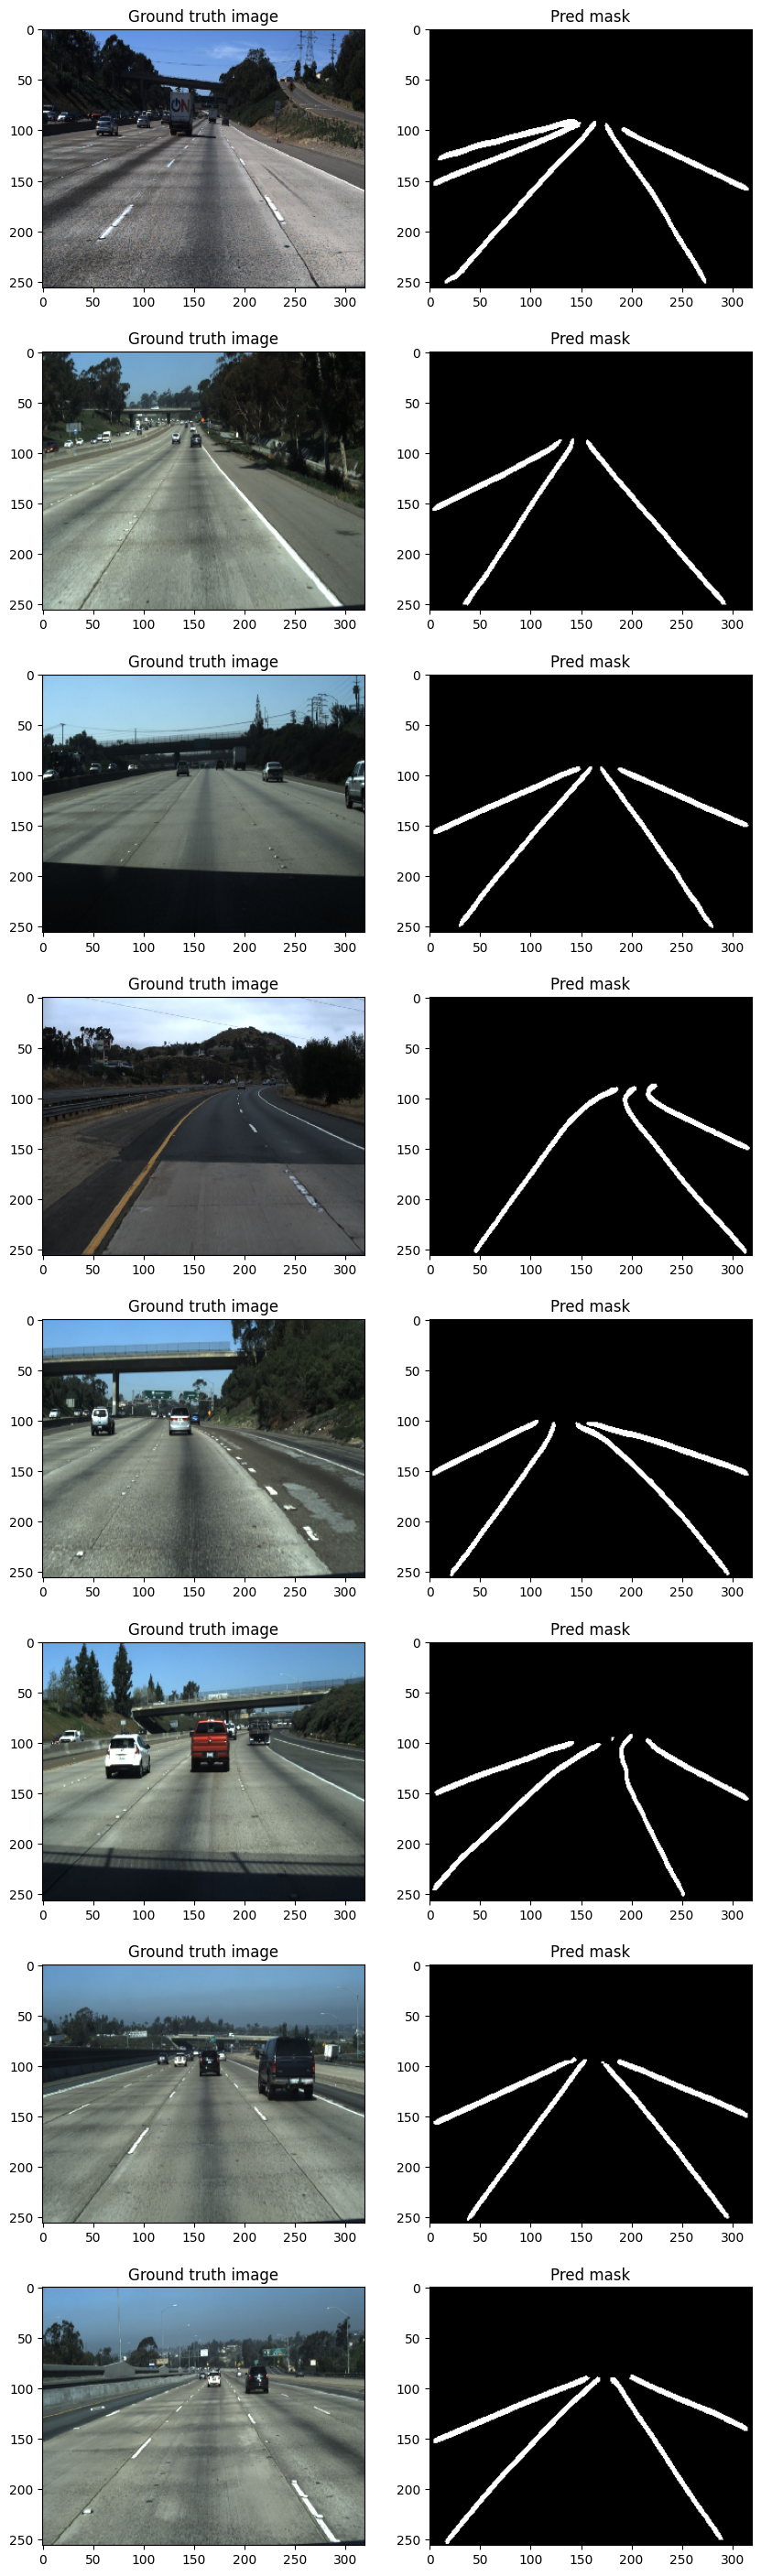

In [16]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [17]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recall:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.97897863
Precision: 0.7686643
Recall: 0.73975855
F1 Score:  0.7539344668559255
IoU:  0.605052


In [18]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
from sklearn.metrics import mean_squared_error
import math
# Calculate MSE
mse_value = mean_squared_error(Y_val.flatten(), preds.flatten())

# Calculate RMSE
rmse_value = math.sqrt(mse_value)
# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recall:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)
# Print the results
print("Mean Squared Error (MSE):", mse_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

Accuracy: 0.97897863
Precision: 0.7686643
Recall: 0.73975855
F1 Score:  0.7539344668559255
IoU:  0.605052
Mean Squared Error (MSE): 0.0210213623046875
Root Mean Squared Error (RMSE): 0.1449874556804398


# GRAPHICAL VISUALIZATION OF METRICS

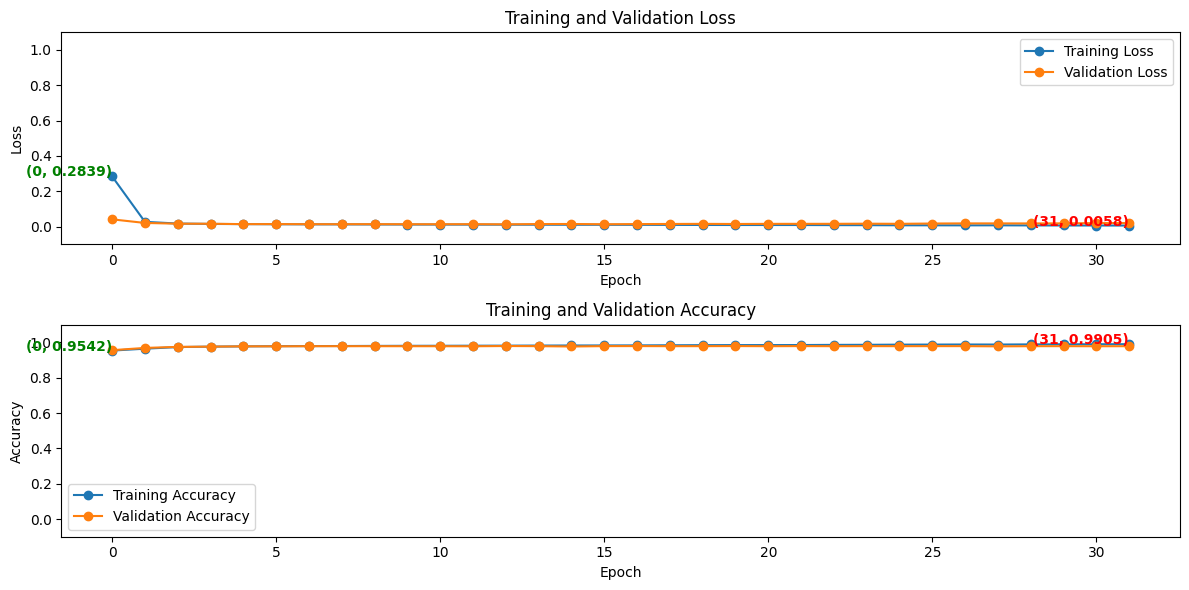

In [19]:
# Plot training and validation metrics with markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for loss with padding

# Display values for starting and ending points on the loss plot
start_loss_coord = (0, history.history['loss'][0])
end_loss_coord = (epochs-1, history.history['loss'][-1])
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for accuracy with padding

# Display values for starting and ending points on the accuracy plot
start_accuracy_coord = (0, history.history['accuracy'][0])
end_accuracy_coord = (epochs-1, history.history['accuracy'][-1])
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.tight_layout()  # Adjust layout for better visualization

plt.show()

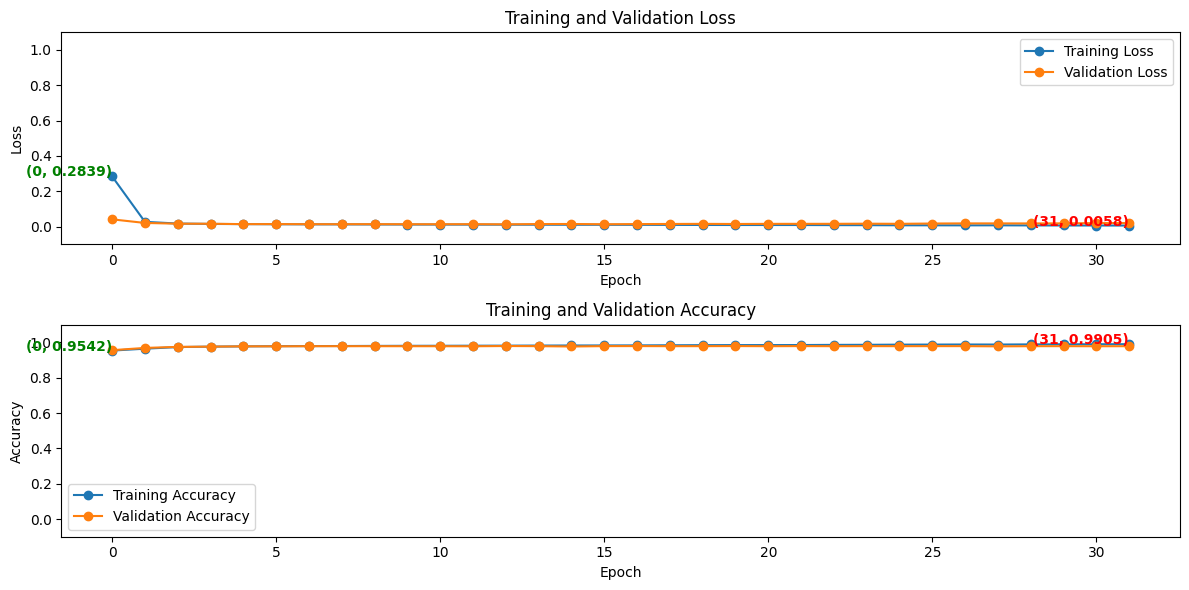

In [20]:
# Plot training and validation metrics with markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for loss with padding

# Display values for starting and ending points on the loss plot
start_loss_coord = (0, history.history['loss'][0])
end_loss_coord = (epochs-1, history.history['loss'][-1])
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for accuracy with padding

# Display values for starting and ending points on the accuracy plot
start_accuracy_coord = (0, history.history['accuracy'][0])
end_accuracy_coord = (epochs-1, history.history['accuracy'][-1])
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.tight_layout()  # Adjust layout for better visualization

# Save the plot to a file
plt.savefig('training_validation_plot.png')

# Show the plot
plt.show()

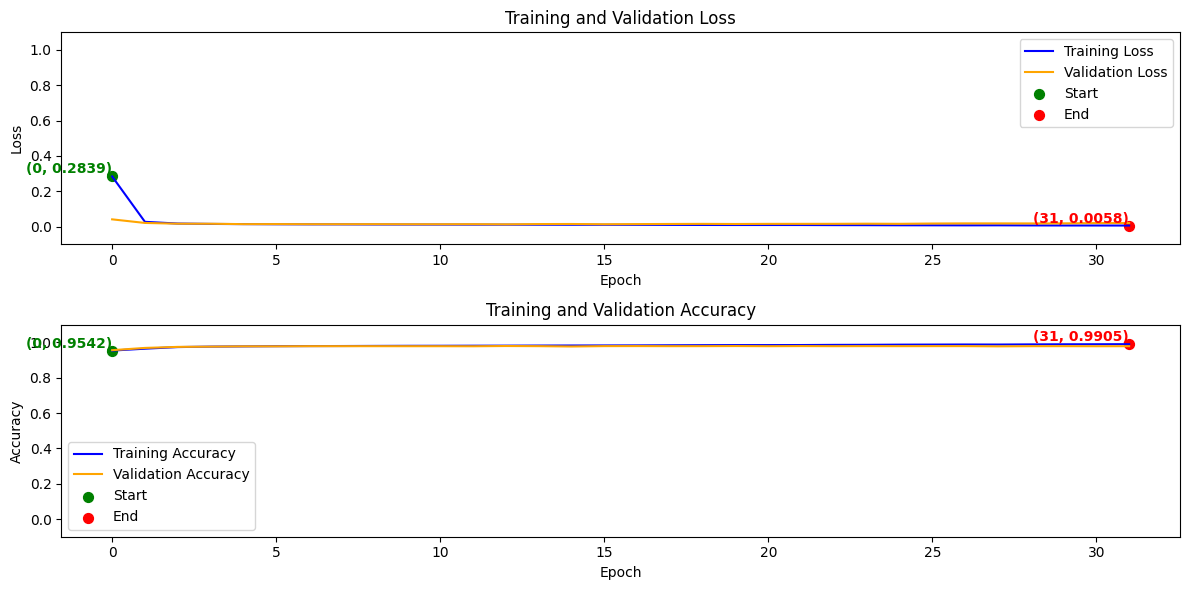

In [21]:
# Plot training and validation metrics with dot markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

# Plot without 'o' marker for all epochs
plt.plot(history.history['loss'], label='Training Loss', marker='None', linestyle='-', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='None', linestyle='-', color='orange')

# Dot marker for starting point
plt.scatter(*start_loss_coord, color='green', s=50, label='Start') 

# Dot marker for ending point
plt.scatter(*end_loss_coord, color='red', s=50, label='End')  

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for loss with padding

# Display values for starting and ending points on the loss plot
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize=10, ha='right', va='bottom', weight='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize=10, ha='right', va='bottom', weight='bold')

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot without 'o' marker for all epochs
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='None', linestyle='-', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='None', linestyle='-', color='orange')

# Dot marker for starting point
plt.scatter(*start_accuracy_coord, color='green', s=50, label='Start')  

# Dot marker for ending point
plt.scatter(*end_accuracy_coord, color='red', s=50, label='End')  

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for accuracy with padding

# Display values for starting and ending points on the accuracy plot
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize=10, ha='right', va='bottom', weight='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize=10, ha='right', va='bottom', weight='bold')

plt.tight_layout()  # Adjust layout for better visualization

# Save the plot to a file
plt.savefig('training_validation_plot.png')

# Show the plot
plt.show()

## RECALL CURVE

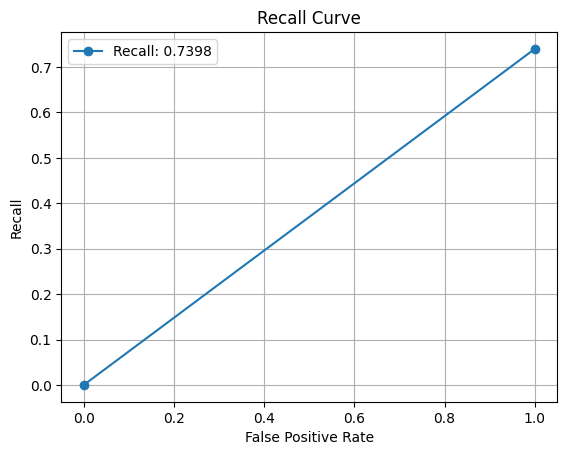

In [22]:
from sklearn.metrics import recall_score

# Calculate recall
recall_val = recall_score(Y_val.flatten(), preds.flatten())

# Plot Recall Curve
plt.plot([0, 1], [0, recall_val], label=f'Recall: {recall_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig('recall_curve.png')
plt.show()

## PRECISION CURVE

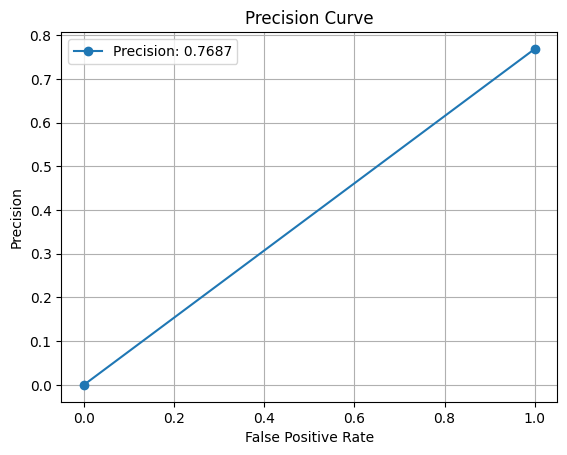

In [23]:
from sklearn.metrics import precision_score

# Calculate precision
precision_val = precision_score(Y_val.flatten(), preds.flatten())

# Plot Precision Curve
plt.plot([0, 1], [0, precision_val], label=f'Precision: {precision_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.grid(True)
plt.savefig('precision_curve.png')
plt.show()

## PRECISION RECALL CURVE

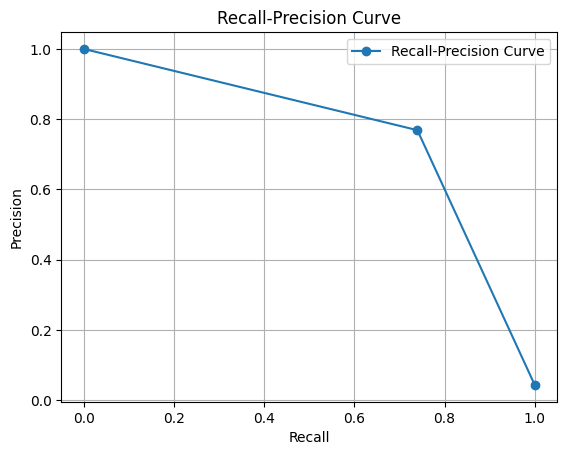

In [24]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(Y_val.flatten(), preds.flatten())

# Plot Recall-Precision Curve
plt.plot(recall, precision, label='Recall-Precision Curve', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
plt.legend()
plt.grid(True)
plt.savefig('recall_precision_curve.png')
plt.show()

## F1 SCORE

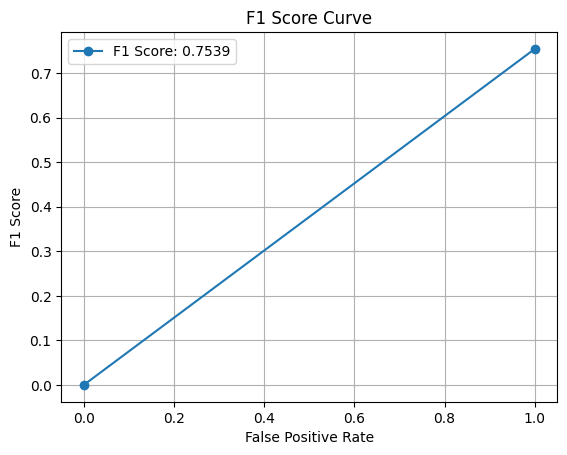

In [25]:
from sklearn.metrics import f1_score

# Calculate F1 Score
f1_score_val = f1_score(Y_val.flatten(), preds.flatten())

# Plot F1 Score Curve
plt.plot([0, 1], [0, f1_score_val], label=f'F1 Score: {f1_score_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.grid(True)
plt.savefig('f1_score_curve.png')
plt.show()

## ACCURACY CURVE

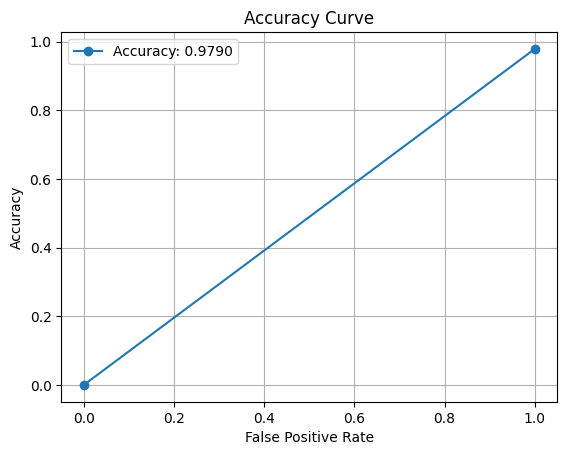

In [26]:
# Plot Accuracy Curve
plt.plot([0, 1], [0, accuracy_value], label=f'Accuracy: {accuracy_value:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png')
plt.show()

## IoU CURVE

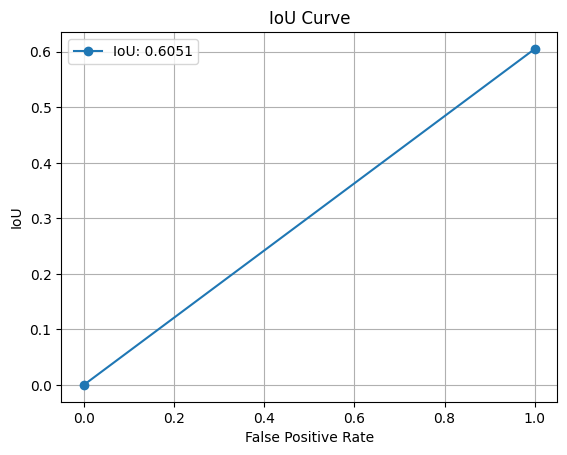

In [27]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_val.flatten(), preds.flatten())

# Calculate True Positive, False Positive, False Negative
tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

# Calculate IoU (Jaccard Index)
iou_val = tp / (tp + fp + fn)

# Plot IoU Curve
plt.plot([0, 1], [0, iou_val], label=f'IoU: {iou_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('IoU')
plt.title('IoU Curve')
plt.legend()
plt.grid(True)
plt.savefig('iou_curve.png')
plt.show()

## PRECISION-RECALL CURVE(WITH VALUES)`

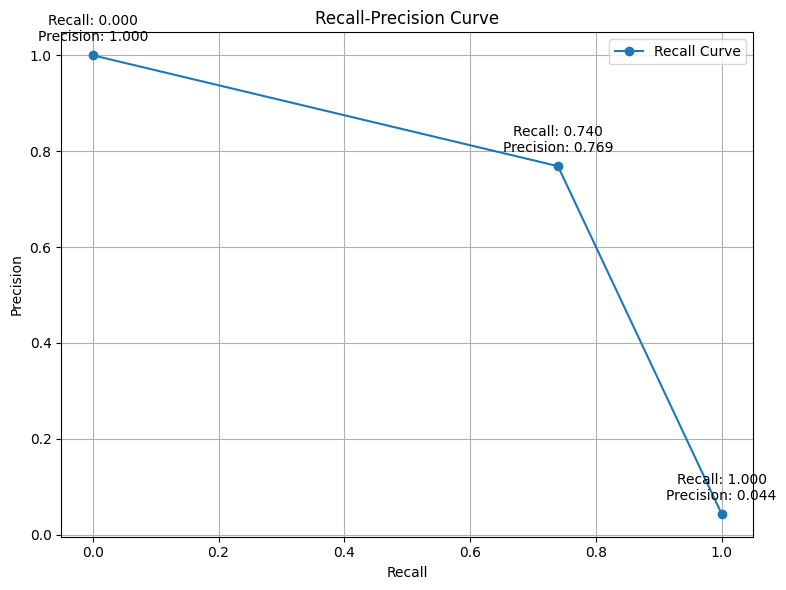

In [28]:
# Plot Recall Curve with values
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Recall Curve', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
plt.legend()

# Annotate Recall and Precision values on the plot
for i, txt in enumerate(recall):
    plt.annotate(f'Recall: {recall[i]:.3f}\nPrecision: {precision[i]:.3f}', (recall[i], precision[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Show the Recall Curve plot
plt.grid(True)
plt.tight_layout()
plt.show()

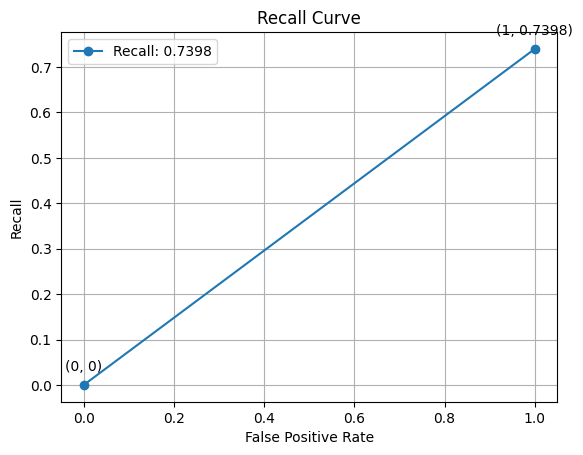

In [29]:
from sklearn.metrics import recall_score

# Calculate recall
recall_val = recall_score(Y_val.flatten(), preds.flatten())

# Plot Recall Curve
plt.plot([0, 1], [0, recall_val], label=f'Recall: {recall_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()

# Annotate starting and ending point values
plt.annotate(f'(0, 0)', (0, 0), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'(1, {recall_val:.4f})', (1, recall_val), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.savefig('recall_curve.png')
plt.show()


## ROC CURVE

Area Under the Curve (AUC): 0.86


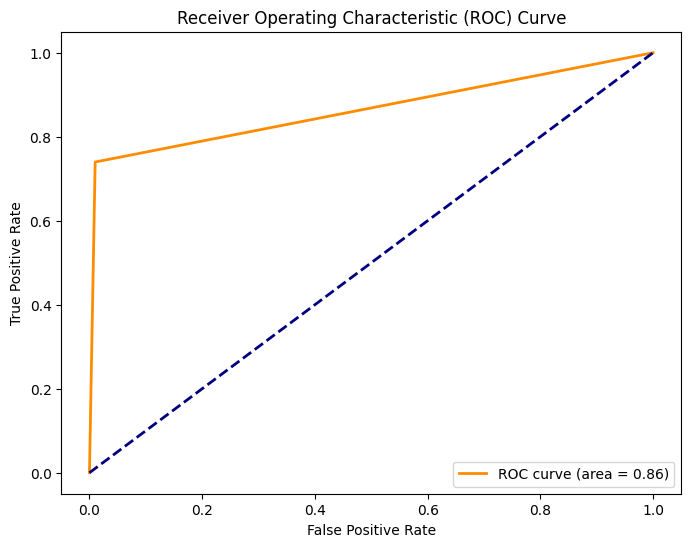

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming preds and Y_val are numpy arrays

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(Y_val.flatten(), preds.flatten())

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Print AUC value
print("Area Under the Curve (AUC): {:.2f}".format(roc_auc))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
